### Importação de Bibliotecas 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

%matplotlib inline


In [45]:
def find_outliers_IQR(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1

    outliers = df[column][((df[column] < (q1 - 1.5 * IQR))
                           | (df[column] > (q3 + 1.5 * IQR)))]

    return outliers.index

### Visualização Inicial dos Dados

In [46]:
housing_df = pd.read_csv('../data/housing_price_dataset.csv')

housing_df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [47]:
housing_df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [48]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


### Pré-Processamento dos Dados

In [49]:
housing_df.dropna(inplace=True)

In [50]:
indexes_to_remove = set()
for col in [c for c in housing_df.columns if c not in ['Neighborhood', 'YearBuilt']]:
    indexes_to_remove = indexes_to_remove.union(set(find_outliers_IQR(housing_df, col)))

housing_df = housing_df[~housing_df.index.isin(indexes_to_remove)]


In [51]:
housing_df

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065
...,...,...,...,...,...,...
49995,1282,5,3,Rural,1975,100080.865895
49996,2854,2,2,Suburb,1988,374507.656727
49997,2979,5,3,Suburb,1962,384110.555590
49998,2596,5,2,Rural,1984,380512.685957


In [52]:
one_hot_encoding = pd.get_dummies(housing_df['Neighborhood']).astype(np.uint8)
housing_df = housing_df.drop('Neighborhood', axis=1)
housing_df = housing_df.join(one_hot_encoding)


In [53]:
scaler = MinMaxScaler()
columns_to_scale = ['SquareFeet', 'Price']
housing_df[columns_to_scale] = scaler.fit_transform(housing_df[columns_to_scale])


### Separação dos Dados em Treino e Teste

In [54]:
housing_df = housing_df.sample(frac=1).reset_index(drop=True)
X = housing_df.drop('Price', axis=1)
y = housing_df['Price']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [56]:
print('Treino:', len(X_train))
print('Teste:', len(X_test))
#print('Validação:', len(X_val))

Treino: 39952
Teste: 9989


In [57]:
def build_model(data, name='regressor'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=[len(data.keys())]),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ], name=name)

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [58]:
model = build_model(X_train)
model.summary()

Model: "regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                256       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1345 (5.25 KB)
Trainable params: 1345 (5.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.2, verbose=1)

Epoch 1/10
999/999 [==============================] - 2s 2ms/step - loss: 1016.9429 - mae: 12.3076 - mse: 1016.9429 - val_loss: 0.1795 - val_mae: 0.3861 - val_mse: 0.1795
Epoch 2/10
999/999 [==============================] - 2s 2ms/step - loss: 0.4208 - mae: 0.4367 - mse: 0.4208 - val_loss: 0.0352 - val_mae: 0.1530 - val_mse: 0.0352
Epoch 3/10
999/999 [==============================] - 2s 2ms/step - loss: 0.0313 - mae: 0.1443 - mse: 0.0313 - val_loss: 0.0303 - val_mae: 0.1424 - val_mse: 0.0303
Epoch 4/10
999/999 [==============================] - 2s 2ms/step - loss: 0.0301 - mae: 0.1420 - mse: 0.0301 - val_loss: 0.0303 - val_mae: 0.1425 - val_mse: 0.0303
Epoch 5/10
999/999 [==============================] - 2s 2ms/step - loss: 0.0301 - mae: 0.1420 - mse: 0.0301 - val_loss: 0.0303 - val_mae: 0.1424 - val_mse: 0.0303
Epoch 6/10
999/999 [==============================] - 2s 2ms/step - loss: 0.0301 - mae: 0.1420 - mse: 0.0301 - val_loss: 0.0303 - val_mae: 0.1424 - val_mse: 0.0303
Epoch 7/1

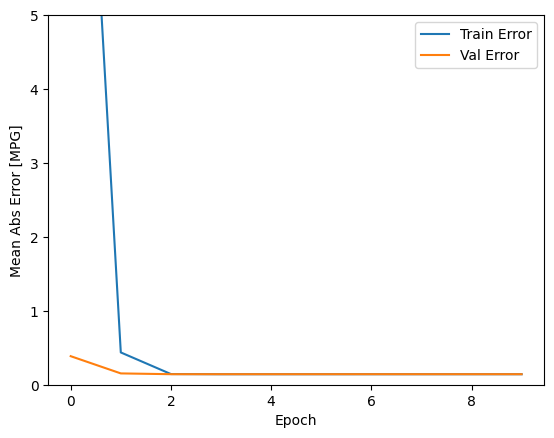

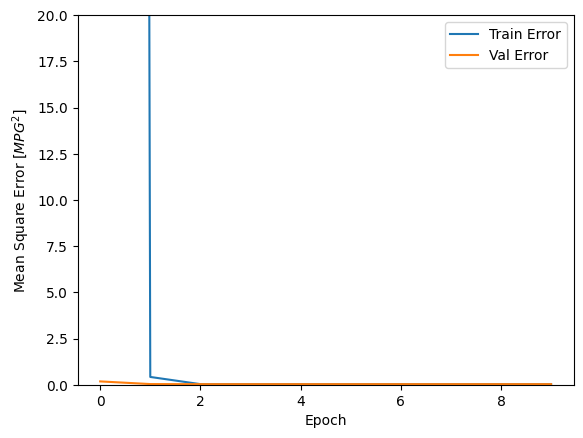

In [60]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.ylim([0, 5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

plot_history(history)

In [61]:
pred = model.predict(X_test)

313/313 [==============================] - 0s 1ms/step


In [62]:
X_test

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Rural,Suburb,Urban
40501,0.930465,5,1,1973,0,0,1
25085,0.351676,4,3,1976,1,0,0
25015,0.274137,4,2,1982,0,1,0
29173,0.159580,3,1,1965,0,0,1
14165,0.057529,3,2,1960,0,0,1
...,...,...,...,...,...,...,...
43629,0.718359,3,2,1956,0,1,0
31479,0.358679,2,1,2003,0,0,1
14768,0.308154,4,1,1986,1,0,0
26812,0.227114,2,3,1984,1,0,0


In [63]:
pred

array([[0.49993214],
       [0.49993214],
       [0.49993214],
       ...,
       [0.49993214],
       [0.49993214],
       [0.49993214]], dtype=float32)

In [64]:
y_test

40501    0.697672
25085    0.213214
25015    0.384663
29173    0.224638
14165    0.133059
           ...   
43629    0.610553
31479    0.468238
14768    0.330933
26812    0.215069
33007    0.285034
Name: Price, Length: 9989, dtype: float64

In [65]:
comparison = pd.concat([pd.DataFrame(y_test).reset_index(), pd.DataFrame(pred)], axis=1).drop('index', axis=1).rename(columns={0: 'pred'})

In [66]:
comparison

,Price,pred
0,0.697672,0.499932
1,0.213214,0.499932
2,0.384663,0.499932
3,0.224638,0.499932
4,0.133059,0.499932
...,...,...
9984,0.610553,0.499932
9985,0.468238,0.499932
9986,0.330933,0.499932
9987,0.215069,0.499932
